In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import matplotlib.pyplot as plt
import os
import numpy as onp
import pandas as pd

import scipy
import time

# for reproducibility of results
random_state = 3101
onp.random.seed(random_state)

data = pd.read_csv("/content/drive/My Drive/data/DSA3101_Hackathon_Data.csv", parse_dates=[1])
data = data.sort_values('Date')
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
421037,Panel 219063101,2017-06-25,Instant Noodles,1,1.0,2.7
204593,Panel 158001101,2017-06-25,Sugar,4,4.0,11.6
204592,Panel 158001101,2017-06-25,Rice,1,10.0,26.0
204501,Panel 157150101,2017-06-25,Tonic Food Drink,1,0.5,15.5
836495,Panel 426083101,2017-06-25,Bouilon,1,0.1,2.6


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['Week'] = le.fit_transform(data.Date)
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend,Week
421037,Panel 219063101,2017-06-25,Instant Noodles,1,1.0,2.7,0
204593,Panel 158001101,2017-06-25,Sugar,4,4.0,11.6,0
204592,Panel 158001101,2017-06-25,Rice,1,10.0,26.0,0
204501,Panel 157150101,2017-06-25,Tonic Food Drink,1,0.5,15.5,0
836495,Panel 426083101,2017-06-25,Bouilon,1,0.1,2.6,0


In [ ]:
num_cat = len(data.Category.unique())
num_panel = len(data['Panel ID'].unique())
print(f"Number of Categories:{num_cat} \t Number of Panels:{num_panel}")

Number of Categories:62 	 Number of Panels:3236


In [ ]:
data_df = data.groupby(by=["Panel ID", "Category"]).agg({'Week': lambda x: max(x)}).reset_index()
data_df

,Panel ID,Category,Week
0,Panel 101011101,Biscuits,151
1,Panel 101011101,Bouilon,152
2,Panel 101011101,Butter,147
3,Panel 101011101,CSD,151
4,Panel 101011101,Cake,89
...,...,...,...
97133,Panel 801912801,Ice Cream,139
97134,Panel 801912801,Liquid Milk,130
97135,Panel 801912801,MSG,139
97136,Panel 801912801,Rice,132


In [ ]:
data_df['Panel ID'].value_counts()

Panel 800619001    62
Panel 203123101    54
Panel 801069201    54
Panel 403041101    54
Panel 212065101    54
                   ..
Panel 105059101     2
Panel 801750101     2
Panel 801598901     2
Panel 800134901     1
Panel 332118101     1
Name: Panel ID, Length: 3236, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X = data_df.loc[:,['Panel ID', 'Category']]
y = data_df.Week
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=random_state, stratify=df['Panel ID'])

# # sanity check to ensure that the split is stratified
# X_train['Panel ID'].value_counts()

In [ ]:
# add rating column to train and test dataframe
train = X.assign(rating=y.values)
# train = X_train.assign(rating=y_train.values)
# test = X_test.assign(rating=y_test.values)
pivot = train.pivot_table(index='Panel ID', columns='Category', values='rating')
global_mean = onp.nanmean(pivot)
subset = onp.where(onp.isfinite(pivot.values))
pivot

Category,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panel 101011101,NaN,NaN,NaN,NaN,151.0,152.0,147.0,151.0,89.0,148.0,112.0,89.0,147.0,NaN,36.0,148.0,153.0,143.0,152.0,NaN,152.0,147.0,104.0,NaN,148.0,146.0,152.0,NaN,153.0,148.0,85.0,NaN,NaN,7.0,140.0,NaN,17.0,79.0,NaN,151.0,141.0,135.0,76.0,NaN,NaN,22.0,NaN,48.0,152.0,67.0,NaN,136.0,92.0,148.0,109.0,NaN,152.0,31.0,143.0,NaN,NaN,NaN
Panel 101016101,NaN,NaN,NaN,NaN,140.0,151.0,NaN,NaN,NaN,NaN,NaN,117.0,NaN,NaN,117.0,NaN,NaN,83.0,154.0,NaN,151.0,154.0,112.0,NaN,56.0,NaN,151.0,NaN,151.0,97.0,NaN,NaN,NaN,NaN,98.0,NaN,NaN,NaN,NaN,128.0,NaN,144.0,129.0,NaN,NaN,NaN,NaN,NaN,151.0,97.0,NaN,151.0,46.0,NaN,NaN,NaN,151.0,69.0,148.0,NaN,NaN,NaN
Panel 101019101,NaN,NaN,142.0,NaN,149.0,NaN,NaN,87.0,104.0,140.0,NaN,97.0,NaN,NaN,NaN,119.0,155.0,155.0,152.0,NaN,152.0,149.0,152.0,NaN,136.0,NaN,155.0,NaN,96.0,115.0,78.0,NaN,NaN,107.0,155.0,NaN,117.0,NaN,70.0,17.0,154.0,106.0,NaN,NaN,NaN,79.0,NaN,65.0,155.0,NaN,NaN,155.0,131.0,14.0,NaN,NaN,155.0,106.0,155.0,NaN,143.0,NaN
Panel 101024101,NaN,NaN,NaN,NaN,153.0,145.0,NaN,133.0,107.0,150.0,108.0,57.0,110.0,NaN,NaN,27.0,NaN,155.0,NaN,123.0,144.0,153.0,NaN,NaN,152.0,NaN,153.0,NaN,141.0,153.0,136.0,NaN,25.0,108.0,148.0,87.0,133.0,NaN,4.0,107.0,155.0,153.0,NaN,NaN,NaN,14.0,134.0,132.0,144.0,155.0,16.0,142.0,155.0,132.0,151.0,NaN,150.0,153.0,141.0,NaN,141.0,97.0
Panel 105009103,NaN,NaN,NaN,NaN,155.0,152.0,NaN,NaN,91.0,153.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,153.0,155.0,154.0,151.0,NaN,NaN,154.0,154.0,NaN,NaN,NaN,NaN,NaN,NaN,153.0,155.0,NaN,132.0,NaN,NaN,NaN,NaN,NaN,154.0,NaN,NaN,NaN,NaN,NaN,148.0,NaN,NaN,155.0,NaN,140.0,NaN,NaN,155.0,144.0,155.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Panel 801900701,NaN,NaN,NaN,NaN,150.0,143.0,NaN,NaN,NaN,143.0,NaN,NaN,NaN,NaN,NaN,NaN,143.0,NaN,151.0,NaN,143.0,140.0,NaN,NaN,NaN,NaN,142.0,NaN,143.0,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.0,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,143.0,NaN,NaN,142.0
Panel 801901201,NaN,NaN,NaN,NaN,155.0,137.0,NaN,150.0,155.0,152.0,150.0,155.0,NaN,NaN,NaN,154.0,NaN,155.0,155.0,155.0,155.0,155.0,NaN,NaN,152.0,NaN,155.0,NaN,150.0,153.0,149.0,NaN,NaN,142.0,150.0,NaN,NaN,NaN,155.0,152.0,140.0,142.0,NaN,NaN,147.0,154.0,NaN,NaN,154.0,142.0,NaN,150.0,155.0,150.0,NaN,NaN,152.0,NaN,140.0,NaN,NaN,NaN
Panel 801903201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.0,129.0,NaN,131.0,NaN,NaN,130.0,131.0,130.0,131.0,NaN,NaN,131.0,NaN,NaN,NaN,NaN,129.0,NaN,NaN,131.0,NaN,NaN,NaN,NaN,131.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.0,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,131.0


In [ ]:
%%time
# naive models
def naive(x):
    if x == 'global mean':
        return onp.sqrt(onp.sum((train.rating.values - global_mean)**2) / train.shape[0])
        # return onp.sqrt(onp.sum((test.rating.values - global_mean)**2) / test.shape[0])
    cost = 0
    if x == 'panel mean':
        df = pd.DataFrame({'Panel ID': onp.sort(train['Panel ID'].unique()), 
                           'panel_mean': onp.nanmean(pivot, 1)})
        df = train.merge(df, how="left", on="Panel ID")
        # df = test.merge(df, how="left", on="Panel ID")
        cost += onp.sum((df.rating - df.panel_mean)**2)
    elif x == 'cat mean':
        df = pd.DataFrame({'Category': onp.sort(train['Category'].unique()), 
                           'cat_mean': onp.nanmean(pivot, 0)})
        df = train.merge(df, how="left", on="Category")
        # df = test.merge(df, how="left", on="Category")
        cost += onp.sum((df.rating - df.cat_mean)**2)
    return np.sqrt(cost/train.shape[0])

# Using global mean
naive_global_mean = naive('global mean')
print('RMSE using global mean:', naive_global_mean)
      
# Using Panel mean
naive_panel_mean = naive('panel mean')
print('RMSE using Panel mean:', naive_panel_mean)

# Using Category mean
naive_cat_mean = naive('cat mean')
print('RMSE using Category mean:', naive_cat_mean)

RMSE using global mean: 47.3710053559159
RMSE using Panel mean: 31.818051821085028
RMSE using Category mean: 46.44262465812979
CPU times: user 81.4 ms, sys: 1.94 ms, total: 83.3 ms
Wall time: 82.2 ms


In [ ]:
%%time
# number of factors (latent variables)
d = 3

# start optimisation from this
U_init = onp.random.poisson(int((global_mean/(d**2))**0.5), size=(num_panel, d))
V_init = onp.random.poisson(int((global_mean/(d**2))**0.5), size=(num_cat, d))
print("global mean:{0:.5f} \t minimum entry of U_init@V_init.T:{1:.5f} \t maximum entry of U_init@V_init.T:{2:.5f}".format(
    global_mean, onp.min(U_init@V_init.T), onp.max(U_init@V_init.T)))

def loss(U,V):
    reg = 1e-2    # tweak regularisation here
    cost = np.sum((pivot.values[subset] - (U @ V.T)[subset])**2)
    return cost/train.shape[0] + reg/num_panel*np.linalg.norm(U)**2 + reg/num_cat*np.linalg.norm(V)**2

def RMSE(df, U, V, reg=False):
    cost = 0.
    panel_df = data_df['Panel ID'].unique()
    panel_df.sort()
    cat_df = data_df['Category'].unique()
    cat_df.sort()
    for p, c, r in df.values:
        # cost += (r - max(0, min(155, (U[panel_df==p] @ V[cat_df==c].T).ravel())))**2    # keep rating values within 0 and 155
        cost += (r - (U[panel_df==p] @ V[cat_df==c].T).ravel())**2    # keep rating values within 0 and 155
    if reg:
        return np.sqrt(cost/df.shape[0]) + reg/num_panel*np.linalg.norm(U)**2 + reg/num_cat*np.linalg.norm(V)**2
    else:
        return np.sqrt(cost/df.shape[0])

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

global mean:109.22835 	 minimum entry of U_init@V_init.T:0.00000 	 maximum entry of U_init@V_init.T:137.00000
CPU times: user 6.18 ms, sys: 2.99 ms, total: 9.17 ms
Wall time: 9.21 ms


CPU times: user 15.2 s, sys: 10.2 s, total: 25.4 s
Wall time: 13.2 s


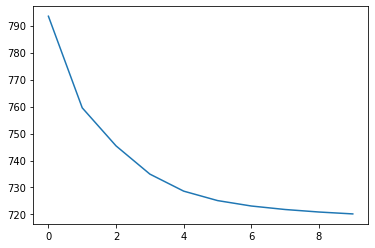

In [ ]:
%%time
#let us define a function that does a few steps of LBFGS with U fixed
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(num_cat, d)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(num_cat, d)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #function to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    
    V_final = traj["x"].reshape(num_cat, d)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(num_panel,d)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(num_panel,d)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #function to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(num_panel,d)
    return U_final

U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 50
n_iter = 10
loss_history_train = []

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history_train.append(loss(U,V))

# gradient descent plot
plt.plot(loss_history_train)

In [ ]:
%%time
print(f"RMSE(train): {round(RMSE(train, U, V), 3)}")

RMSE(train): [26.732]
CPU times: user 10 s, sys: 8.06 ms, total: 10 s
Wall time: 10.1 s


In [ ]:
%%time
print(f"Improvement from Worst Naive Model (Using Global Mean) by {round(100*(1 - RMSE(train, U, V)/naive_global_mean), 1)}%")
print(f"Improvement from Best Naive Model (Using Panel Mean) by {round(100*(1 - RMSE(train, U, V)/naive_panel_mean), 1)}%")

Improvement from Worst Naive Model (Using Global Mean) by [43.6]%
Improvement from Best Naive Model (Using Panel Mean) by [16.]%
CPU times: user 21.5 s, sys: 10 ms, total: 21.5 s
Wall time: 22 s
